In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, SpectralClustering
from sklearn import metrics

%matplotlib inline

In [2]:
RGB_wide = pickle.load(open('RGB_wide.pickle', 'rb'))
RGB_labels = pickle.load(open('RGB_labels.pickle', 'rb'))

In [3]:
print(type(RGB_wide), type(RGB_labels))
print(RGB_wide.shape, len(RGB_labels))

<class 'numpy.ndarray'> <class 'list'>
(27000, 12288) 27000


In [4]:
RGB_wide_center = RGB_wide - RGB_wide.mean()
RGB_labels = np.asarray(RGB_labels)
type(RGB_labels)

numpy.ndarray

In [5]:
X_train, X_test, y_train, y_test = train_test_split(RGB_wide_center, RGB_labels, test_size = 0.2, 
                                                    random_state = 423, stratify = RGB_labels)

In [6]:
def plot_PCA_2D(df, groups, group_labels, file = None, 
                n_components = 2, random_state = None):
    """
    Takes a centered DataFrame or array, conducts a principal components
    analysis (PCA), and plots the scores of the first two components colored
    by input group labels. Axis labels display the percentage of variance 
    explained by each component.

    Parameters
    ----------
    df: DataFrame or ndarray
    groups: Series or ndarray
        The groups to color the scores by
        length must equal df.shape[0]
    group_labels: one-dimensional array
        The unique labels for the groups
    file: string, default: None
        Filename to save plot output with
    n_components: int, default: 2
        The number of principal components to keep
    random_state: int, default: None

    Returns
    -------
    scatterplot
        scores plot of PC2 vs. PC1 colored by group_labels  
    """

    import matplotlib.pyplot as plt
    from itertools import cycle

    pca = PCA(n_components = n_components, random_state = random_state)
    pca.fit(df)
    scores = pca.transform(df)
    perc_var_explained = pca.explained_variance_ratio_

    colors = cycle(['r', 'g', 'b', 'c', 'm', 'y', 'orange', 'w', 'aqua', 
                    'yellow', 'black', 'brown'])
    plt.figure(figsize = (12, 10))
    for c, label in zip(colors, group_labels):
        plt.scatter(scores[groups == label, 0], scores[groups == label, 1],
                    c = c, label = label, edgecolors = 'gray')
    plt.xlabel('PC1 ({}% Variance)'.format((100 * perc_var_explained[0])\
                .round(2)), fontsize = 15)
    plt.ylabel('PC2 ({}% Variance)'.format((100 * perc_var_explained[1])\
                .round(2)), fontsize = 15)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend()

    if file:
        plt.savefig(file, dpi = 100, bbox_inches = 'tight')
    plt.show()
    plt.close()

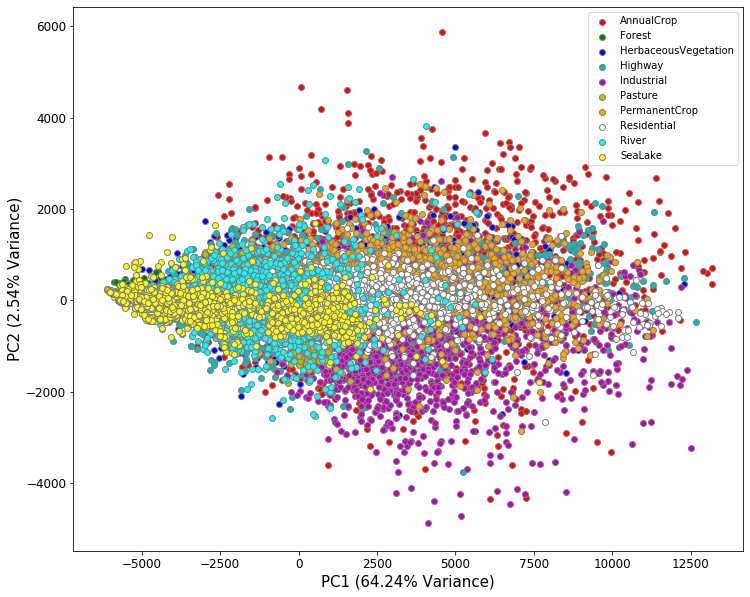

In [7]:
plot_PCA_2D(X_train, y_train, np.unique(y_train), file = 'pca_scores_RGB.png', random_state = 423)

In [8]:
RGB_pca = PCA(n_components = 500, random_state = 423).fit(X_train)
RGB_train_scores = RGB_pca.transform(X_train)
RGB_test_scores = RGB_pca.transform(X_test)

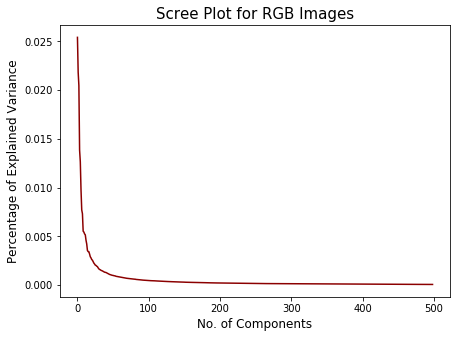

In [9]:
plt.figure(figsize = (7, 5))
plt.plot(RGB_pca.explained_variance_ratio_[1:], color = 'darkred')
plt.xlabel('No. of Components', fontsize = 12)
plt.ylabel('Percentage of Explained Variance', fontsize = 12);
plt.title('Scree Plot for RGB Images', fontsize = 15)
plt.show()
plt.close()

In [10]:
np.min(np.where(np.cumsum(RGB_pca.explained_variance_ratio_) >= 0.9))

118

In [11]:
RGB_train_scores.shape

(21600, 500)

In [12]:
RGB_train_reduce = RGB_train_scores[:, 0:120]  # extract the first 120 PCs
RGB_test_reduce = RGB_test_scores[:, 0:120]

In [13]:
def display_clusters(data, model_fit = [], num_clusters = 0, file = None):
    color = ['r', 'g', 'b', 'c', 'm', 'y', 'black', 'orange', 'aqua', 'yellow', 'brown']
    plt.figure(figsize = (12, 10))
    
    if num_clusters == 0:
        plt.scatter(data[:, 0], data[:, 1], c = color[0], alpha = 0.5, s = 20)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        
    else:
        for i in range(num_clusters):
            plt.scatter(data[model_fit.labels_ == i, 0], data[model_fit.labels_ == i, 1], 
                        c = color[i], alpha = 0.5, s = 20)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        
    if file:
        plt.savefig(file, dpi = 100, bbox_inches = 'tight')
    plt.show()
    plt.close()
        
def cluster_metrics(model_fit, labels, data):
    print('Homogeneity: {}'.format(metrics.homogeneity_score(labels, model_fit.labels_)))
    print('Completeness: {}'.format(metrics.completeness_score(labels, model_fit.labels_)))
    print('V-measure: {}'.format(metrics.v_measure_score(labels, model_fit.labels_)))
    print('Silhouette Coefficient: {}'.format(metrics.silhouette_score(data, model_fit.labels_,
                                                                 metric = 'euclidean')))

    
def print_contingency_matrix(contingency_matrix, class_names, figsize = (10,7), fontsize = 18):
    """
    Takes a contingency matrix as returned by sklearn.metrics.contingency_matrix and returns it
    as a heatmap.
    
    Parameters
    ---------
    contingency_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.contingency_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order that they index the given contingency matrix.
    figsize: tuple
        A 2-tuple, the first value determining the horizontal size of the output figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axis labels. Defaults to 18.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix heatmap
    """
    
    df_cm = pd.DataFrame(contingency_matrix, index = class_names, columns = class_names, )
    plt.figure(figsize = figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot = True, fmt = "d", cmap = 'viridis')
    except ValueError:
        raise ValueError("Contingency matrix values must be integers.")
    
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, 
                                 ha = 'right', fontsize = fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 45, 
                                 ha = 'right', fontsize = fontsize, rotation_mode = 'anchor')
    plt.ylabel('True Class', fontsize = 15, style = 'italic')
    plt.xlabel('Cluster Assignment', fontsize = 15, style = 'italic')
    
    plt.show()
    plt.close()

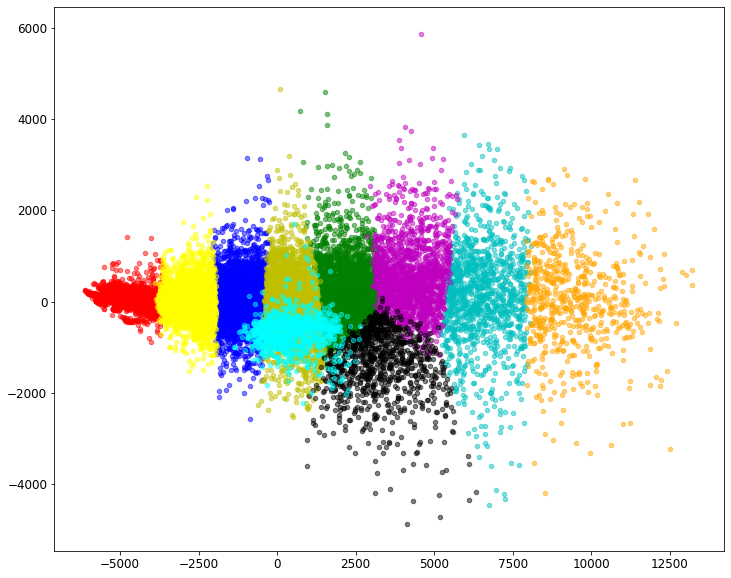

In [14]:
RGB_km = KMeans(n_clusters = 10, init = 'k-means++', n_init = 10, random_state = 423, n_jobs = -1)
RGB_km.fit(RGB_train_reduce)
display_clusters(RGB_train_reduce, RGB_km, num_clusters = 10, file = 'RGB_reduced_clusters_kmeans.png')

In [15]:
cluster_metrics(RGB_km, y_train, RGB_train_reduce)

Homogeneity: 0.24880655205980612
Completeness: 0.2657966912944523
V-measure: 0.2570211484825462
Silhouette Coefficient: 0.13870541134897738


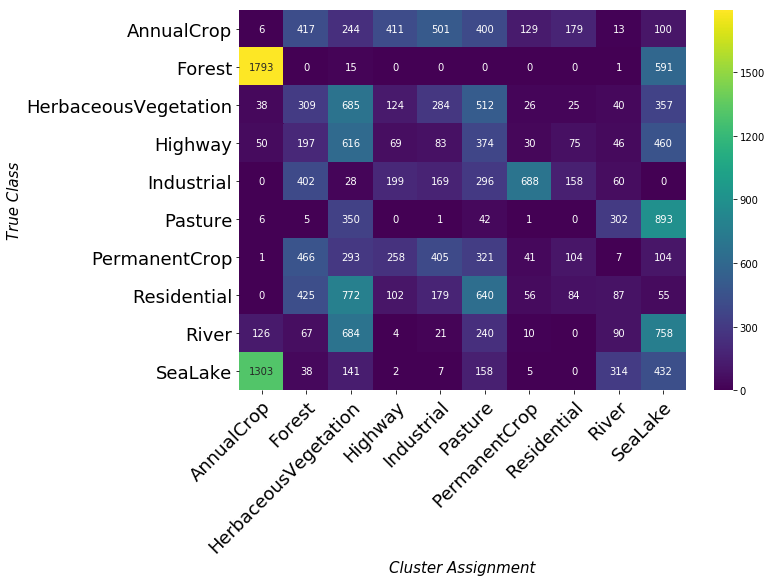

In [16]:
labels_unique = np.unique(y_train)
print_contingency_matrix(metrics.cluster.contingency_matrix(y_train, RGB_km.labels_), labels_unique)

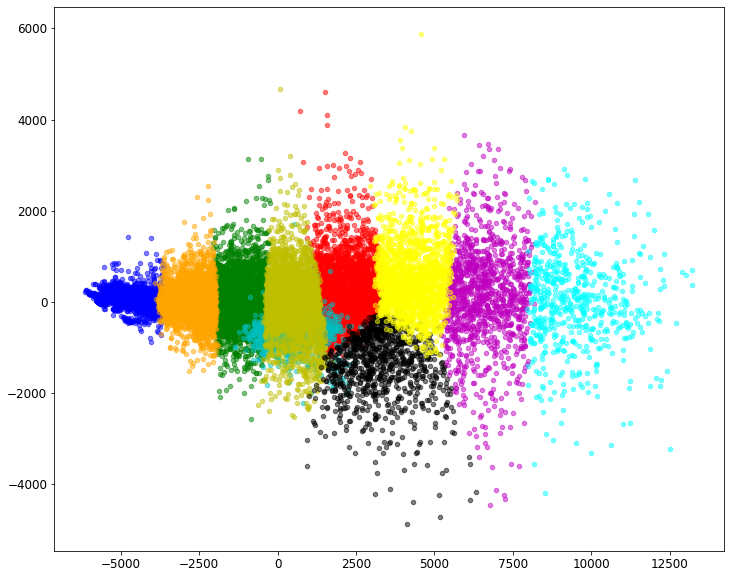

In [15]:
RGB_km2 = KMeans(n_clusters = 10, init = 'k-means++', n_init = 10, random_state = 423, n_jobs = -1)
RGB_km2.fit(RGB_train_scores)
display_clusters(RGB_train_scores, RGB_km2, num_clusters = 10, file = 'RGB_full_clusters_kmeans.png')

In [18]:
cluster_metrics(RGB_km2, y_train, RGB_train_scores)

Homogeneity: 0.2487466775089377
Completeness: 0.26605949502211895
V-measure: 0.2571119731571024
Silhouette Coefficient: 0.11798607500498545


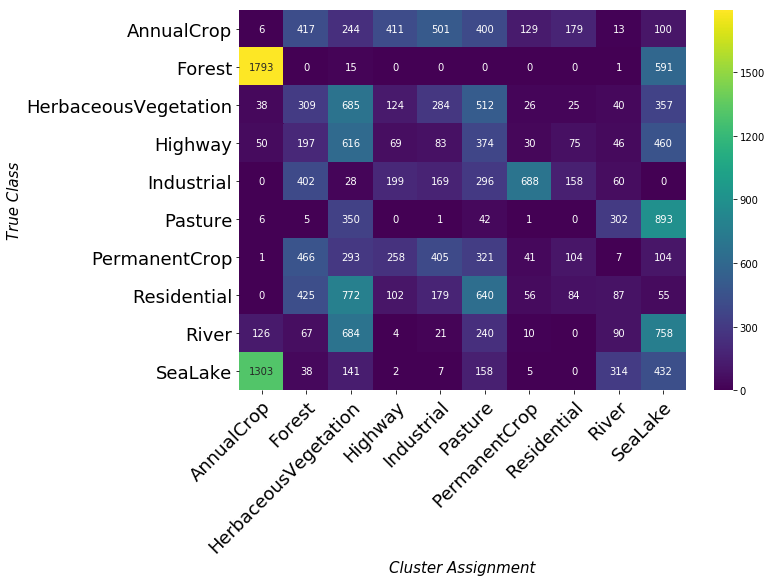

In [19]:
print_contingency_matrix(metrics.cluster.contingency_matrix(y_train, RGB_km.labels_), labels_unique)

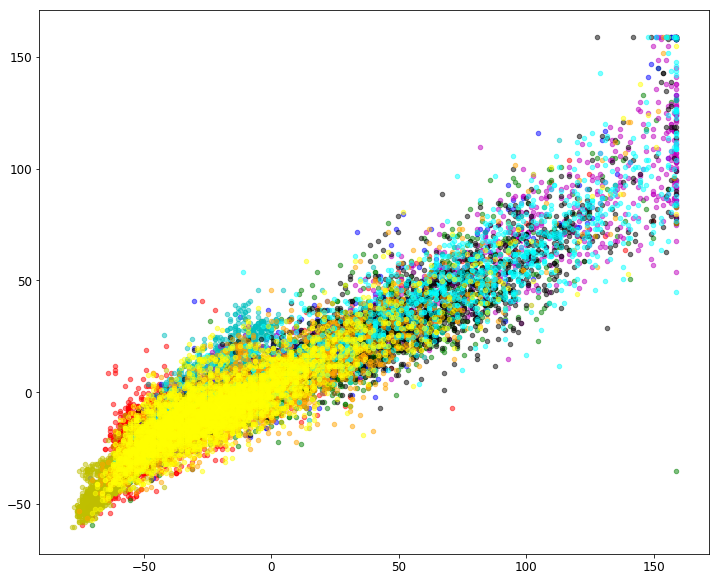

In [20]:
RGB_km3 = KMeans(n_clusters = 10, init = 'k-means++', n_init = 10, random_state = 423, n_jobs = -1)
RGB_km3.fit(X_train)
display_clusters(X_train, RGB_km3, num_clusters = 10)

In [21]:
cluster_metrics(RGB_km3, y_train, X_train)

Homogeneity: 0.2488399600201515
Completeness: 0.2665490155809981
V-measure: 0.25739024123758675
Silhouette Coefficient: 0.10446729370469951


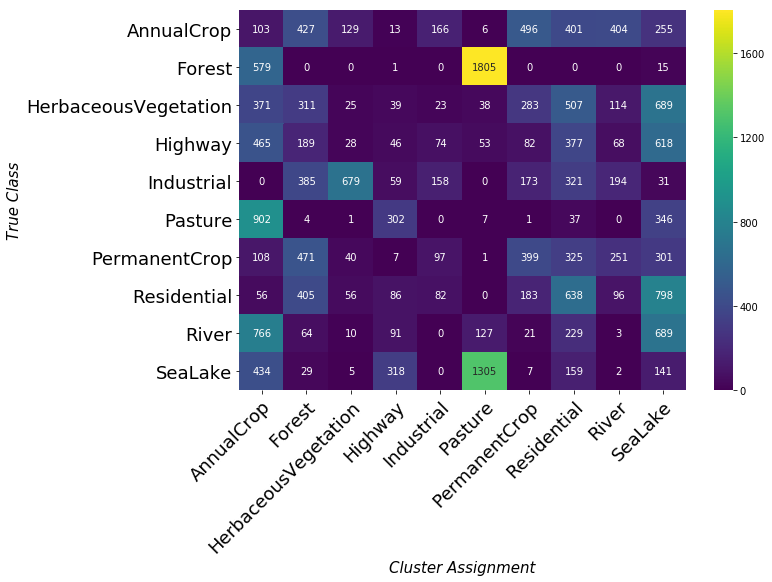

In [22]:
print_contingency_matrix(metrics.cluster.contingency_matrix(y_train, RGB_km3.labels_), labels_unique)

In [31]:
inertia_scores = []
silhouette_coef = []
list_num_clusters = list(range(2, 21))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters = num_clusters, init = 'k-means++', n_init = 8, random_state = 423, n_jobs = -1)
    km.fit(RGB_train_reduce)
    inertia_scores.append(km.inertia_)
    silhouette_coef.append(metrics.silhouette_score(RGB_train_reduce, km.labels_, metric = 'euclidean'))

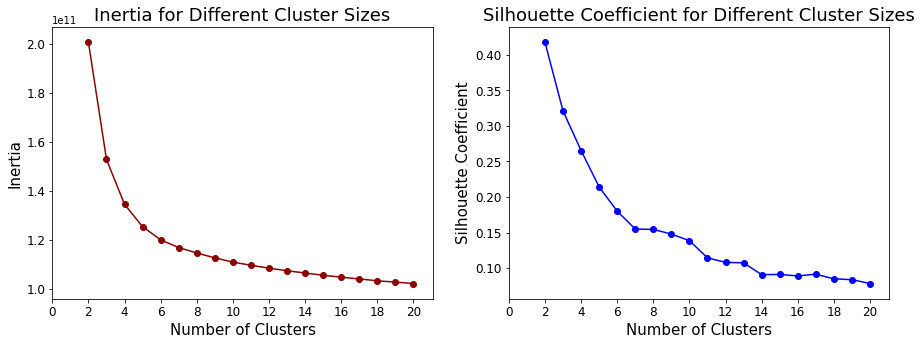

In [34]:
plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
plt.plot(list_num_clusters, inertia_scores, color = 'darkred')
plt.scatter(list_num_clusters, inertia_scores, color = 'darkred')
plt.title('Inertia for Different Cluster Sizes', fontsize = 18)
plt.xlabel('Number of Clusters', fontsize = 15)
plt.ylabel('Inertia', fontsize = 15)
plt.xticks(np.arange(0, 21, 2), fontsize = 12)
plt.yticks(fontsize = 12)

plt.subplot(1, 2, 2)
plt.plot(list_num_clusters, silhouette_coef, color = 'blue')
plt.scatter(list_num_clusters, silhouette_coef, color = 'blue')
plt.title('Silhouette Coefficient for Different Cluster Sizes', fontsize = 18)
plt.xlabel('Number of Clusters', fontsize = 15)
plt.ylabel('Silhouette Coefficient', fontsize = 15)
plt.xticks(np.arange(0, 21, 2), fontsize = 12)
plt.yticks(fontsize = 12)

plt.show()
plt.close()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


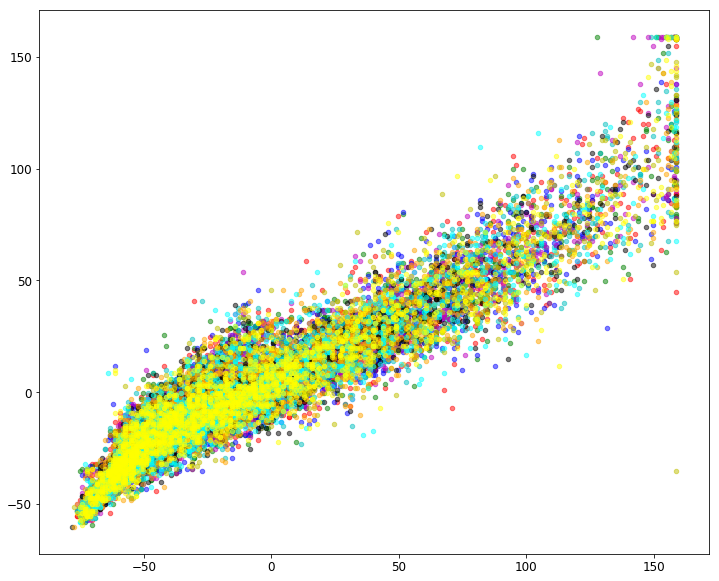

In [38]:
spectral = SpectralClustering(n_clusters = 10, affinity = 'rbf', random_state = 423, 
                              n_jobs = -1, assign_labels = 'discretize')
spectral.fit(X_train)
display_clusters(X_train, spectral, num_clusters = 10)

In [39]:
cluster_metrics(spectral, y_train, X_train)

Homogeneity: 0.001220944695056191
Completeness: 0.0012203014875846918
V-measure: 0.0012206230065858797
Silhouette Coefficient: -0.012782304727684683


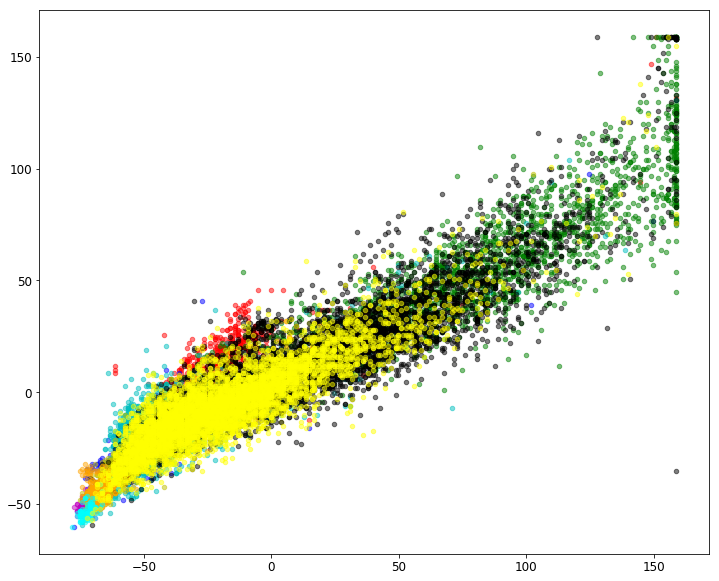

In [40]:
spectral2 = SpectralClustering(n_clusters = 10, affinity = 'nearest_neighbors', n_neighbors = 100,
                               random_state = 423, n_jobs = -1, assign_labels = 'discretize')
spectral2.fit(X_train)
display_clusters(X_train, spectral2, num_clusters = 10)

In [41]:
cluster_metrics(spectral2, y_train, X_train)

Homogeneity: 0.2481443945685714
Completeness: 0.30447261741948395
V-measure: 0.27343773960364137
Silhouette Coefficient: 0.030977393576194997


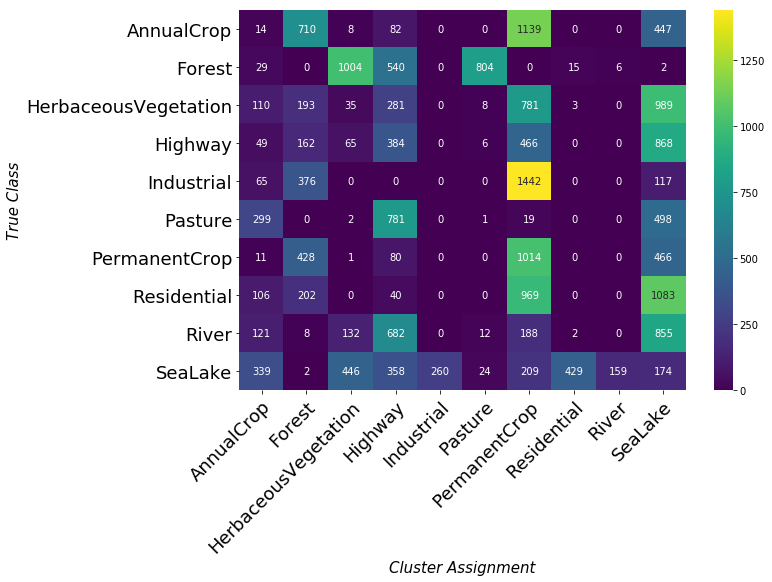

In [42]:
print_contingency_matrix(metrics.cluster.contingency_matrix(y_train, spectral2.labels_), labels_unique)

In [47]:
pickle.dump(RGB_train_reduce, open('RGB_train_reduce.pickle', 'wb'))
pickle.dump(RGB_test_reduce, open('RGB_test_reduce.pickle', 'wb'))
pickle.dump(y_train, open('RGB_train_labels.pickle', 'wb'))
pickle.dump(y_test, open('RGB_test_labels.pickle', 'wb'))